## Autoencoder-Decoder Models for Abnormal Data in Energy Systems Implementation

この例では、ノイズ除去オートエンコーダを実装しています。ノイズ除去オートエンコーダは、データを圧縮して再構成することによって、データの基本的なパターンを学習するように設計されたニューラルネットワークの一種であり、異常なデータを処理する（データのセグメントから異常なノイズをフィルタリングするなど）という特定の目的を持っています。 エネルギーシステムの文脈では、このオートエンコーダは、エネルギー消費量、電圧測定値、温度測定値などの時系列データを処理するために使用できます。これらのデータには、センサーのエラー、通信の問題、または予期しない環境条件による異常なノイズや異常が含まれていることがよくあります。 きれいな信号パターンと様々な形の複雑なノイズを組み合わせたシーケンスで学習することで、オートエンコーダはデータ内の真のパターンをノイズや異常値から区別することを学習する。 実際のエネルギー・システムのデータに適用すると、学習したモデルはノイズのない正確な信号表現を再構築し、異常な測定値を効果的に識別して緩和することができます。 このアプローチは、エネルギー・システムの監視と保守のための貴重なツールであり、その後の分析や制御の決定で使用されるデータが正確で信頼できることを保証し、システム全体の効率と安定性を高めるのに役立ちます。

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(50)
np.random.seed(50)    

以下の関数は、複数の正弦波信号を合成して複雑な信号にし、オートエンコーダにとって挑戦的なものにするためにさまざまな種類のノイズを加えることによって、合成データセットを作成する。

In [8]:
# Step 1: Generate Complex Synthetic Dataset
def generate_complex_sequence(length=50, num_sequences=1000, noise_factor=0.5):
    x = np.linspace(0, 4 * np.pi, length)
    
    # Create complex clean signal by combining sinusoids of different frequencies
    clean_sequences = np.array([
        np.sin(x + np.random.uniform(0, 2 * np.pi)) + 
        0.5 * np.sin(2 * x + np.random.uniform(0, 2 * np.pi)) + 
        0.25 * np.sin(4 * x + np.random.uniform(0, 2 * np.pi)) 
        for _ in range(num_sequences)
    ])
    
    # Add complex noise: Gaussian noise + occasional spikes + uniform noise
    gaussian_noise = noise_factor * np.random.normal(size=clean_sequences.shape)
    spike_noise = np.random.choice([0, 1], size=clean_sequences.shape, p=[0.98, 0.02]) * np.random.uniform(-3, 3, size=clean_sequences.shape)
    uniform_noise = noise_factor * np.random.uniform(-1, 1, size=clean_sequences.shape)
    
    noisy_sequences = clean_sequences + gaussian_noise + spike_noise + uniform_noise
    return torch.tensor(noisy_sequences, dtype=torch.float32), torch.tensor(clean_sequences, dtype=torch.float32)


以下の関数は、異なる周波数の正弦波成分を組み合わせて複素クリーン信号を生成する。

In [9]:
# Generate data
noisy_data, clean_data = generate_complex_sequence()
train_noisy, test_noisy, train_clean, test_clean = train_test_split(noisy_data, clean_data, test_size=0.2)

In [16]:
noisy_data.shape,clean_data.shape

(torch.Size([1000, 50]), torch.Size([1000, 50]))

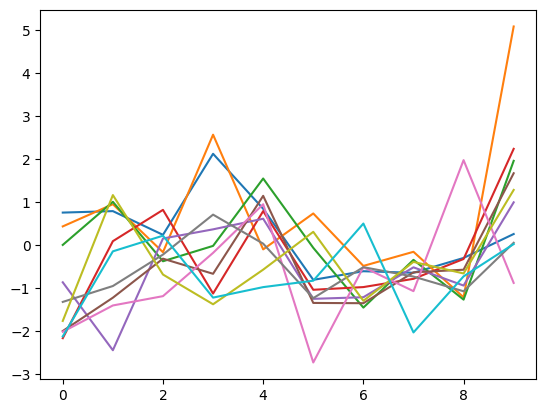

In [17]:
plt.plot(noisy_data[:10,:10])
# plt.plot(clean_data)
plt.show()

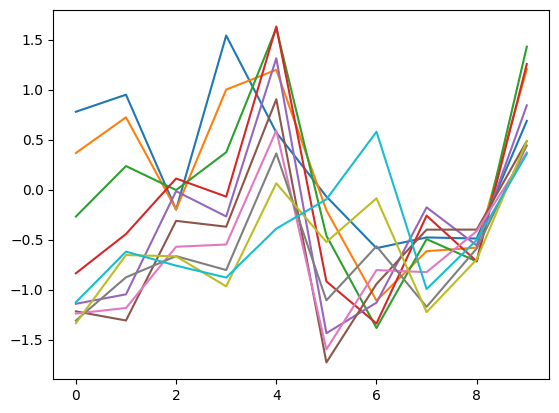

In [18]:
plt.plot(clean_data[:10,:10])
plt.show()


Step2

In [20]:
# Step 2: Define the Autoencoder Model
# Step 2: Define the Autoencoder Model with Initialization
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )
        
        # Initialize weights
        self.apply(self._init_weights)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)  # Xavier initialization for weights
            if module.bias is not None:
                init.zeros_(module.bias)  # Initialize biases to zero

In [21]:
# Model, loss function, and optimizer
input_size = train_noisy.shape[1]
hidden_size = 64
model = DenoisingAutoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Step 3: Train the Autoencoder
num_epochs = 1000
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0,len(train_noisy),batch_size):
        batch_noisy = train_noisy[i:i+batch_size]
        batch_clean = train_clean[i:i+batch_size]

        outputs = model(batch_noisy)
        loss = criterion(outputs,batch_clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], loss : {loss.item():.4f}")

Epoch [10/1000], loss : 0.0582
Epoch [20/1000], loss : 0.0364
Epoch [30/1000], loss : 0.0278
Epoch [40/1000], loss : 0.0228
Epoch [50/1000], loss : 0.0191
Epoch [60/1000], loss : 0.0169
Epoch [70/1000], loss : 0.0152
Epoch [80/1000], loss : 0.0135
Epoch [90/1000], loss : 0.0124
Epoch [100/1000], loss : 0.0113
Epoch [110/1000], loss : 0.0234
Epoch [120/1000], loss : 0.0091
Epoch [130/1000], loss : 0.0121
Epoch [140/1000], loss : 0.0087
Epoch [150/1000], loss : 0.0101
Epoch [160/1000], loss : 0.0105
Epoch [170/1000], loss : 0.0189
Epoch [180/1000], loss : 0.0200
Epoch [190/1000], loss : 0.0075
Epoch [200/1000], loss : 0.0071
Epoch [210/1000], loss : 0.0061
Epoch [220/1000], loss : 0.0085
Epoch [230/1000], loss : 0.0102
Epoch [240/1000], loss : 0.0120
Epoch [250/1000], loss : 0.0167
Epoch [260/1000], loss : 0.0070
Epoch [270/1000], loss : 0.0055
Epoch [280/1000], loss : 0.0036
Epoch [290/1000], loss : 0.0029
Epoch [300/1000], loss : 0.0034
Epoch [310/1000], loss : 0.0035
Epoch [320/1000],

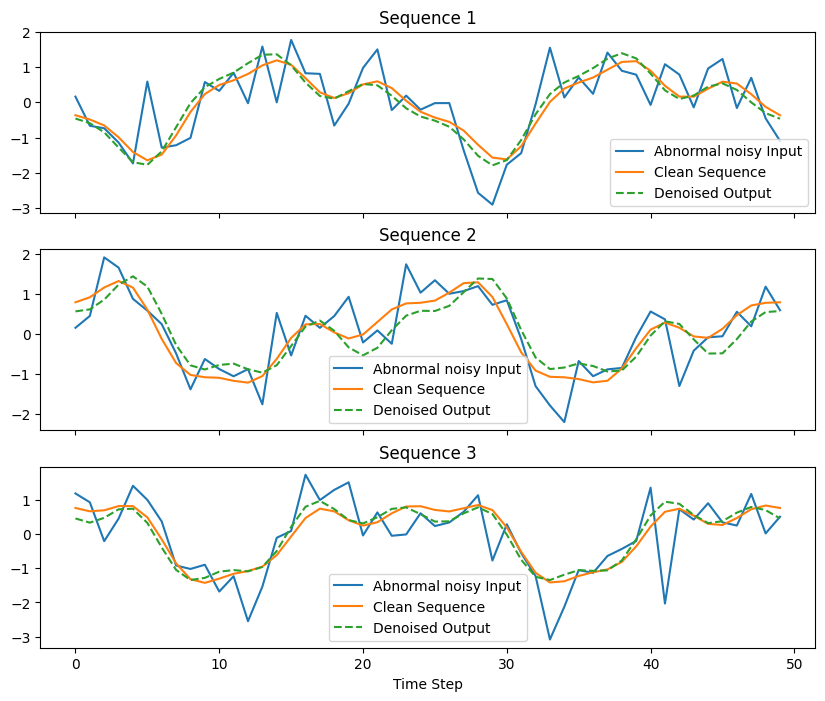

In [25]:
# Step 4: Visualize Results
def visualize_results(model, noisy_data, clean_data):
    model.eval()
    with torch.no_grad():
        test_outputs = model(noisy_data)
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for i in range(3):
        axs[i].plot(noisy_data[i].numpy(), label='Abnormal noisy Input')
        axs[i].plot(clean_data[i].numpy(), label='Clean Sequence')
        axs[i].plot(test_outputs[i].numpy(), label='Denoised Output', linestyle='dashed')
        axs[i].legend()
        axs[i].set_title(f'Sequence {i+1}')
    
    plt.xlabel('Time Step')
    plt.show()

# Visualize on test data
visualize_results(model, test_noisy, test_clean)   
